In [1]:
from glob import glob
import pandas as pd
import networkx as nx
import numpy as np
import math
import pickle
'''
Though not explicitly stated, I believe this "stopwords" package originates
from this pip package: https://pypi.org/project/stop-words/

It was the first result I found that shares the same name and get_stop_words
function call. 
'''
import stop_words
from dateutil import parser
from collections import defaultdict, Counter
import re
from nltk.stem import WordNetLemmatizer

# don't condense large numbers to scientific notation
pd.set_option('float_format', '{:f}'.format)

filenames = glob("data/BTC/*.csv")
stopwords = set(stop_words.get_stop_words('en'))
stopwords.update(['quote', 'pmquote', 'amquote', 'just', 'don', 'one', 'thing', 'even', 'way', 'maybe', 'also', 'please', 'well', 'actually', 'something',
                                         'going', 'anything', 'le', 'ever', 'say', 'see', 'likely', 'per', 'another', 'someone', 'let', 'anyone', 'doesn', 'include', 'doe', 'exactly',
                                         'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'like',
                                         'said', 'guy', 'will', 'can', 'able', 'people', 'become', 'tell', 'hey', 'much', 'many', 'lol', 'lot', 'want', 'still', 'really', 'think', 'didn',
                                         'isn', 'post', 'edited', 'share', 'facebookshare', 'twitter'])
lemmatizer = WordNetLemmatizer()


In [2]:
'''
Current preprocessing protocol

Remove:
Hyperlinks
Characters not in the English alphabetical character set a-z or A-Z
stopwords
words less than 3 characters
'bitcoins' and replace with 'bitcoin'

'''
def parse_string(input_string):
    input_string = input_string.lower()
    # remove links
    input_string = re.sub(r'http\S+', ' ', input_string)
    input_string = re.sub(r'\S+.(com|org)', '', input_string)
    # remove all non-English alphabet characters including numbers,
    # foreign and special characters
    input_string = re.sub( "[^a-zA-Z]", " ", input_string).split()

    # lemmatize word
    words = [lemmatizer.lemmatize(w) for w in input_string]
    # get rid of stopwords and words less than 3 characters
    words = [w for w in words if w not in stopwords and len(w) > 2]
    # change bitcoins to bitcoin
    words = [w if w != 'bitcoins' else 'bitcoin' for w in words]
    return words


In [3]:
total_posts = 0
total_reple = 0
preprocessed_data = {}
preprocessed_data['user_network'] = nx.DiGraph()

# a dictionary of user's posts, their time, quantity
# accessed via preprocessed_data[field][user_name]
preprocessed_data['time_posts'] = defaultdict(list)
preprocessed_data['user_time_posts'] = defaultdict(dict)
preprocessed_data['user_posts'] = defaultdict(list)
preprocessed_data['user_posts_num'] = defaultdict(int)
preprocessed_data['get_comment_num'] = defaultdict(int)
preprocessed_data['write_comment_num'] = defaultdict(int)
preprocessed_data['posts'] = []
voca = set()
word_freq = Counter()


fields = ['user_name', 'created_at', 'text', 'id', 'user_verified', 'in_reply_to_screen_name']

df = pd.concat([pd.read_csv(filename, nrows=100000, usecols=fields) for filename in filenames])


df["user_name"].dropna(inplace=True)
df["in_reply_to_screen_name"].dropna(inplace=True)
df["created_at"].dropna(inplace=True)

df.reset_index(inplace=True)

df.sort_values("user_name", inplace=True)

if len(df[df.index.duplicated()]) > 0:
    print("duplicate indices found! Something went wrong.")

In [4]:
'''
Construct a new dataframe from the existing data in order to construct our digraph. The old
code assumes that for each post, there is a number of comments directly linked to that post.
For this dataset, however, each comment is linked to a user, which is still enough info to 
construct the graph, but does not allow us to process it in the same manner. 

The code below, therefore will link together user_name and a set of comments. 
Importantly, if the user the comments are directed towards doesn't exist, their total 
comments will be zero, as we can derive nothing from them. 
'''

user_comments_dict = {}

counter = 0

# create dictionary which maps usernames to a set of comment indices
# start by looping through comments
for index, user_name in df["in_reply_to_screen_name"].items(): 

    if counter % 10000 == 0:
        print(f"\r{counter/len(df) * 100:.2f}% done", end='')

    counter += 1

    # skip nan values
    if type(user_name) == float:
        continue

    user_loc = df['user_name'].searchsorted(user_name)

    # the user this comment is pointing to doesn't have a post
    if df.iloc[user_loc]['user_name'] != user_name:
        continue

    if user_name in user_comments_dict:
        user_comments_dict[user_name].add(index)
    #  user has comments, init and add it here
    else:
        user_comments_dict[user_name] = set([index])


print(f"\r{100:.2f}% done", end='')

100.00% done

In [5]:
# user_comments_dict
# df['user_name'].searchsorted("#A'FaceBook'ThatPays")

# df.iloc[1]

In [6]:
# update word count, takes 8 mins or so
for i, text in enumerate(df["text"]):

    if i % 10000 == 0:
        print(f"\r{i/len(df) * 100:.2f}% done", end='')
        
    text_body = parse_string(text)
    word_freq.update(text_body)

print(f"\r{100:.2f}% done", end='')

# with open('word_freq.pkl', 'rb') as f:
#     word_freq = pickle.load(f)


100.00% done

In [7]:
user_processed_dict = {}

counter = 0
total_edges = sum([len(comments) for comments in user_comments_dict.values()])

voca = set()

min_post_len = 5
min_comment_len = 5
min_word_freq = 10

total_len = len(df[df["in_reply_to_screen_name"].isna()])

# only loop through posts. Comments will be counted if the user is found
# to be in the comments_user_dict 
# note: takes roughly 15 minutes on my machine
for row in df[df["in_reply_to_screen_name"].isna()].itertuples():

    # absolute index, not implicit
    index = row.Index

    if counter % 5000 == 0:
        print(f"\r{counter/total_len * 100:.2f}% done", end='')

    counter += 1

    post_body = parse_string(row.text)
    post_body = [w for w in post_body if word_freq[w] >= 10]
    
    # skip posts of four words or less
    if len(post_body) < min_post_len:
        continue

    voca.update(post_body)
    post_user = row.user_name
    posted_time = parser.parse(row.created_at).date()
    
    preprocessed_data['user_posts'][post_user].append(post_body)
    preprocessed_data['user_posts_num'][post_user] += 1
    preprocessed_data['time_posts'][posted_time].append(post_body)

    # also add the same post data to a dictionary accessible by
    # the user_name and time
    if posted_time in preprocessed_data['user_time_posts'][post_user]:
        preprocessed_data['user_time_posts'][post_user][posted_time].append(post_body)
    else:
        preprocessed_data['user_time_posts'][post_user][posted_time] = [post_body]
    
    preprocessed_data['posts'].append(post_body)

    # skip any posts that don't have comments
    if not(post_user in user_comments_dict):
        continue

    # comments already processed for this user
    if post_user in user_processed_dict:
        continue

    # loop through the comments for the post and construct the digraph
    for comment in df.loc[user_comments_dict[post_user]].itertuples():

        user_processed_dict[post_user] = True

        # skip comments on own post
        if comment.user_name == post_user:
            continue

        comment_body = parse_string(comment.text)
        comment_body = [w for w in comment_body if word_freq[w] >= min_word_freq]
        
        if len(comment_body) < min_comment_len:
            continue

        voca.update(comment_body)
        comment_user = comment.user_name
        comment_time = parser.parse(comment.created_at).date()
            
        preprocessed_data['user_posts'][comment_user].append(comment_body)
        preprocessed_data['time_posts'][comment_time].append(comment_body)

        if posted_time in preprocessed_data['user_time_posts'][post_user]:
            preprocessed_data['user_time_posts'][post_user][posted_time].append(post_body)
        else:
            preprocessed_data['user_time_posts'][post_user][posted_time] = [post_body]
        
        preprocessed_data['posts'].append(comment_body)
        preprocessed_data['user_network'].add_edge(comment_user, post_user)
        preprocessed_data['get_comment_num'][post_user] = len(user_comments_dict[post_user])
        preprocessed_data['write_comment_num'][comment_user] += 1
            

print(f"\r{100:.2f}% done", end='')
print(f"\n{100*preprocessed_data['user_network'].number_of_edges()/total_edges:.2f}% edge utilization", end='')
print("\npickling...")

voca = list(voca)
preprocessed_data['voca'] = voca
preprocessed_data['word_freq'] = word_freq
with open("preprocessed_bitcoin.pkl", 'wb') as f:
    pickle.dump(preprocessed_data, f)

print("finished")



100.00% done
50.74% edge utilization
pickling...
finished


/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8383 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 127487 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 127462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 127790 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning:

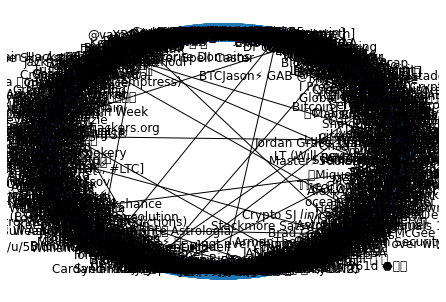

In [9]:
# nx.draw_shell(preprocessed_data["user_network"], with_labels=True)
